In [1]:
import numpy as np
import pandas as pd
from dask import dataframe as dd
import matplotlib.pyplot as plt
from scipy.stats import kendalltau
from scipy.stats import rankdata
from scipy.stats import norm
import fastHDMI as mi
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import RidgeCV
from sklearn.metrics import r2_score
import multiprocess as mp
from tqdm import tqdm as tqdm

# Calculate MI for ABIDE data age outcome
## this block is only to be run on Compute Canada

In [ ]:
csv_file = r"/home/kyang/projects/def-cgreenwo/abide_data/abide_fs60_vout_fwhm0_lh_SubjectIDFormatted_N1050_nonzero_withSEX.csv"
# abide = pd.read_csv(csv_file, encoding='unicode_escape', engine="c")
abide = dd.read_csv(csv_file, sample=1250000)

# _abide_name = abide.columns.tolist()[1:]
_abide_name = list(abide.columns)[1:]

# print(_abide_name)

# we don't inlcude age and sex in the screening since they should always be included in the model
abide_name = [_abide_name[-3]] + _abide_name[1:-3]

np.save(r"./ABIDE_columns", _abide_name[1:-3])

# so that the left first column is the outcome and the rest columns are areas

mi_output = mi.continuous_screening_csv_parallel(csv_file,
                                                 _usecols=abide_name,
                                                 csv_engine="c",
                                                 sample=1250000,
                                                 multp=10)
np.save(r"./ABIDE_age_MI_output", mi_output)

pearson_output = mi.Pearson_screening_csv_parallel(csv_file,
                                                   _usecols=abide_name,
                                                   csv_engine="c",
                                                   sample=1250000,
                                                   multp=10)
np.save(r"./ABIDE_age_Pearson_output", pearson_output)

# Plots

In [ ]:
abide_mi = np.load(r"./ABIDE_age_MI_output.npy")
plt.hist(np.log(abide_mi), 500)
plt.show()

In [ ]:
abide_pearson = np.load(r"./ABIDE_age_Pearson_output.npy")
plt.hist(np.log(np.abs(abide_pearson)), 500)
plt.show()

## Comparing two ranking with Kendall's $\tau$

The results show that the two ranking by mutual information and Pearson's correlation vary greatly by Kendall's tau -- I also tried the Pearson's correlation between two ranking (not that I should do this) and the correlation is also very small.

**So in summary, the two ranking vary greatly.**

In [ ]:
plt.scatter(np.log(abide_mi), abide_pearson, s=10,
            alpha=.2)  # s is the dot size
plt.show()
# keep this, add different selections
# PREDICT AGE

In [ ]:
print("Kendall's tau: \n",
      kendalltau(rankdata(-abide_mi), rankdata(-np.abs(abide_pearson))))
print("Pearson's correlation: \n",
      np.corrcoef(rankdata(-abide_mi), rankdata(-np.abs(abide_pearson))))

# Calculate MI for ABIDE data diagnosis outcome
## this block is only to be run on Compute Canada

In [ ]:
csv_file = r"/home/kyang/projects/def-cgreenwo/abide_data/abide_fs60_vout_fwhm0_lh_SubjectIDFormatted_N1050_nonzero_withSEX.csv"
# abide = pd.read_csv(csv_file, encoding='unicode_escape', engine="c")
abide = dd.read_csv(csv_file, sample=1250000)

# _abide_name = abide.columns.tolist()[1:]
_abide_name = list(abide.columns)[1:]

# print(_abide_name)

# we don't inlcude age and sex in the screening since they should always be included in the model
abide_name = [_abide_name[-1]] + _abide_name[1:-3]
# so that the left first column is the outcome and the rest columns are areas

mi_output = mi.binary_screening_csv_parallel(csv_file,
                                             _usecols=abide_name,
                                             csv_engine="c",
                                             sample=1250000,
                                             multp=10)
np.save(r"./ABIDE_diagnosis_MI_output", mi_output)

pearson_output = mi.Pearson_screening_csv_parallel(csv_file,
                                                   _usecols=abide_name,
                                                   csv_engine="c",
                                                   sample=1250000,
                                                   multp=10)
np.save(r"./ABIDE_diagnosis_Pearson_output", pearson_output)

# Plots

In [ ]:
abide_mi = np.load(r"./ABIDE_diagnosis_MI_output.npy")
plt.hist(np.log(abide_mi), 500)
plt.show()

In [ ]:
abide_pearson = np.load(r"./ABIDE_diagnosis_Pearson_output.npy")
plt.hist(np.log(np.abs(abide_pearson)), 500)
plt.show()

## Comparing two ranking with Kendall's $\tau$

The results show that the two ranking by mutual information and Pearson's correlation vary greatly by Kendall's tau -- I also tried the Pearson's correlation between two ranking (not that I should do this) and the correlation is also very small.

**So in summary, the two ranking vary greatly.**

In [ ]:
plt.scatter(np.log(abide_mi), abide_pearson, s=10,
            alpha=.2)  # s is the dot size
plt.show()
# keep this, add different selections
# PREDICT AGE

In [ ]:
print("Kendall's tau: \n",
      kendalltau(rankdata(-abide_mi), rankdata(-np.abs(abide_pearson))))

# Try Fitting models to predict age, $5$-fold CV
## this is just a code block for mutual information screening with `ElasticNetCV` -- for Pearson and for other methods, simply replace certain parts of the code -- the detailed changed are to be found at the Python scripts in `ABIDE_predict_age` directory
## this block of code only means to be run on Compute Canada

In [ ]:
import numpy as np
import pandas as pd
from dask import dataframe as dd
import matplotlib.pyplot as plt
from scipy.stats import kendalltau
from scipy.stats import rankdata
import fastHDMI as mi
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import RidgeCV
from sklearn.metrics import r2_score
import multiprocess as mp
from tqdm import tqdm

csv_file = r"/home/kyang/projects/def-cgreenwo/abide_data/abide_fs60_vout_fwhm0_lh_SubjectIDFormatted_N1050_nonzero_withSEX.csv"
original_df = pd.read_csv(csv_file, encoding='unicode_escape', engine='c')
columns = np.load(r"./ABIDE_columns.npy")
abide_dep = np.load(r"./ABIDE_age_MI_output.npy"
                    )  # for Pearson, use ABIDE_age_Pearson_output.npy


def testing_error(num_covariates=20,
                  training_proportion=.8,
                  fun=ElasticNetCV,
                  outcome_name="AGE_AT_SCAN",
                  seed=1):
    np.random.seed(seed)
    _usecols = np.hstack((outcome_name, "SEX", "DX_GROUP",
                          columns[np.argsort(-abide_dep)][:num_covariates]))
    df = original_df[_usecols].dropna(inplace=False).sample(
        frac=1, random_state=seed, replace=False).reset_index(drop=True,
                                                              inplace=False)
    if df.shape[0] > 20:
        train_test_div = int(np.around(df.shape[0] * training_proportion))
        X_train, y_train = df.iloc[:train_test_div,
                                   1:], df.iloc[:train_test_div, 0]
        X_test, y_test = df.iloc[train_test_div:, 1:], df.iloc[train_test_div:,
                                                               0]
        if fun in [ElasticNetCV, LassoCV]:
            fit = fun(cv=5, random_state=seed, n_jobs=-1).fit(X_train, y_train)
        elif fun in [RidgeCV]:  # RidgeCV doesn't have seed setting
            fit = fun(cv=5).fit(X_train, y_train)
        y_pred = fit.predict(X_test)
        out = r2_score(y_test, y_pred)
    else:
        out = np.nan
    return out


def testing_error_rep(num_covariates=20,
                      training_proportion=.8,
                      fun=ElasticNetCV,
                      outcome_name="AGE_AT_SCAN",
                      num_rep=10):
    def _testing_error(seed):
        return testing_error(num_covariates=num_covariates,
                             training_proportion=training_proportion,
                             fun=fun,
                             outcome_name=outcome_name,
                             seed=seed)

    seeds = np.arange(num_rep)
    return np.array(list(map(_testing_error, seeds)))


def testing_error_num_attr(num_attr,
                           training_proportion=.8,
                           fun=ElasticNetCV,
                           outcome_name="AGE_AT_SCAN",
                           num_rep=10):
    def _testing_error_rep(_num_attr):
        return testing_error_rep(num_covariates=_num_attr,
                                 training_proportion=training_proportion,
                                 fun=fun,
                                 outcome_name=outcome_name,
                                 num_rep=num_rep)

    return np.array(list(map(_testing_error_rep, tqdm(num_attr))))


output = testing_error_num_attr(
    num_attr=list(
        map(int,
            np.around(np.linspace(0, len(columns), 50 + 1)[1:]).tolist())
    ),  # so here it will screen the number of covariates roughly 30 apart
    training_proportion=.8,  # 80/20 training+validation/testing division
    fun=ElasticNetCV,  # here it says to use ElasticNetCV
    outcome_name="AGE_AT_SCAN",
    num_rep=30)
np.save(r"./ABIDE_age_MI_ElasticNetCV", output)

# Comparison of Performance
## Here is just to show the testing set $R^2$ for Ridge Regression

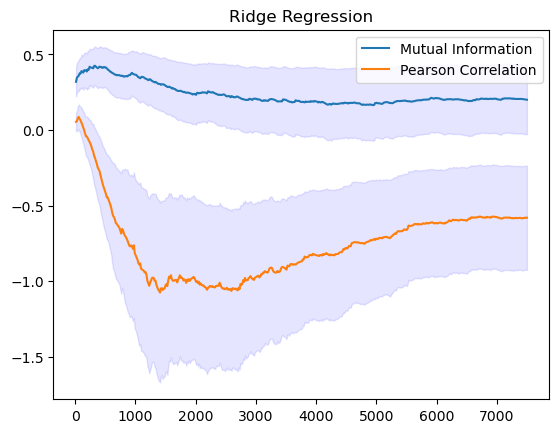

In [17]:
columns = np.load(r"./ABIDE_predict_age/ABIDE_columns.npy")
ABIDE_age_MI_RidgeCV = np.load(r"./ABIDE_predict_age/ABIDE_age_MI_RidgeCV.npy")
ABIDE_age_Pearson_RidgeCV = np.load(
    r"./ABIDE_predict_age/ABIDE_age_Pearson_RidgeCV.npy")
num_attr = np.around(np.linspace(
    0,
    len(columns) / 20, 500 + 1)[1:])  # ADJUST this based on actual settings

MI_RidgeCV_mean = np.mean(ABIDE_age_MI_RidgeCV, 1)
MI_RidgeCV_std = np.std(ABIDE_age_MI_RidgeCV, 1)
Pearson_RidgeCV_mean = np.mean(ABIDE_age_Pearson_RidgeCV, 1)
Pearson_RidgeCV_std = np.std(ABIDE_age_Pearson_RidgeCV, 1)

plt.plot(num_attr, MI_RidgeCV_mean, label="Mutual Information")
plt.fill_between(num_attr,
                 (MI_RidgeCV_mean + MI_RidgeCV_std * norm.ppf(0.025)),
                 (MI_RidgeCV_mean + MI_RidgeCV_std * norm.ppf(0.975)),
                 color='b',
                 alpha=.1)
plt.plot(num_attr, Pearson_RidgeCV_mean, label="Pearson Correlation")
plt.fill_between(
    num_attr, (Pearson_RidgeCV_mean + Pearson_RidgeCV_std * norm.ppf(0.025)),
    (Pearson_RidgeCV_mean + Pearson_RidgeCV_std * norm.ppf(0.975)),
    color='b',
    alpha=.1)
plt.legend()
plt.title(r"Ridge Regression")
plt.show()

In [ ]:
columns = np.load(r"./ABIDE_predict_age/ABIDE_columns.npy")
ABIDE_age_MI_LassoCV = np.load(r"./ABIDE_predict_age/ABIDE_age_MI_LassoCV.npy")
ABIDE_age_Pearson_LassoCV = np.load(
    r"./ABIDE_predict_age/ABIDE_age_Pearson_LassoCV.npy")
num_attr = np.around(np.linspace(
    0,
    len(columns) / 20, 500 + 1)[1:])  # ADJUST this based on actual settings

MI_LassoCV_mean = np.mean(ABIDE_age_MI_LassoCV, 1)
MI_LassoCV_std = np.std(ABIDE_age_MI_LassoCV, 1)
Pearson_LassoCV_mean = np.mean(ABIDE_age_Pearson_LassoCV, 1)
Pearson_LassoCV_std = np.std(ABIDE_age_Pearson_LassoCV, 1)

plt.plot(num_attr, MI_LassoCV_mean, label="Mutual Information")
plt.fill_between(num_attr,
                 (MI_LassoCV_mean + MI_LassoCV_std * norm.ppf(0.025)),
                 (MI_LassoCV_mean + MI_LassoCV_std * norm.ppf(0.975)),
                 color='b',
                 alpha=.1)
plt.plot(num_attr, Pearson_LassoCV_mean, label="Pearson Correlation")
plt.fill_between(
    num_attr, (Pearson_LassoCV_mean + Pearson_LassoCV_std * norm.ppf(0.025)),
    (Pearson_LassoCV_mean + Pearson_LassoCV_std * norm.ppf(0.975)),
    color='b',
    alpha=.1)
plt.legend()
plt.title(r"LASSO")
plt.show()

In [ ]:
columns = np.load(r"./ABIDE_predict_age/ABIDE_columns.npy")
ABIDE_age_MI_ElasticNetCV = np.load(
    r"./ABIDE_predict_age/ABIDE_age_MI_ElasticNetCV.npy")
ABIDE_age_Pearson_ElasticNetCV = np.load(
    r"./ABIDE_predict_age/ABIDE_age_Pearson_ElasticNetCV.npy")
num_attr = np.around(np.linspace(
    0,
    len(columns) / 20, 500 + 1)[1:])  # ADJUST this based on actual settings

MI_ElasticNetCV_mean = np.mean(ABIDE_age_MI_ElasticNetCV, 1)
MI_ElasticNetCV_std = np.std(ABIDE_age_MI_ElasticNetCV, 1)
Pearson_ElasticNetCV_mean = np.mean(ABIDE_age_Pearson_ElasticNetCV, 1)
Pearson_ElasticNetCV_std = np.std(ABIDE_age_Pearson_ElasticNetCV, 1)

plt.plot(num_attr, MI_ElasticNetCV_mean, label="Mutual Information")
plt.fill_between(
    num_attr, (MI_ElasticNetCV_mean + MI_ElasticNetCV_std * norm.ppf(0.025)),
    (MI_ElasticNetCV_mean + MI_ElasticNetCV_std * norm.ppf(0.975)),
    color='b',
    alpha=.1)
plt.plot(num_attr, Pearson_ElasticNetCV_mean, label="Pearson Correlation")
plt.fill_between(
    num_attr,
    (Pearson_ElasticNetCV_mean + Pearson_ElasticNetCV_std * norm.ppf(0.025)),
    (Pearson_ElasticNetCV_mean + Pearson_ElasticNetCV_std * norm.ppf(0.975)),
    color='b',
    alpha=.1)
plt.legend()
plt.title(r"Elastic Net")
plt.show()